In [3]:
import simpy
import numpy as np

# rhyme.code
https://frhyme.github.io/python-lib/simpy_basic/

In [2]:
## 내부에 loop와 yield가 있는 generator입니다. 
## simpy에서는 generator를 기본적으로 사용하는데, 
## generator는 yield를 포함한 연속된 명령 리스트? 라고 생각해도 상관없습니다. 
## yield: return something and hold 
def clock(env, name, tick):
    while True:
        ## clock generator가 한번 불러지면, 아래 행동을 수행 
        print("{:.2f} sec: {} clock ticks".format(env.now, name))
        ## 넘겨 받는 시간만큼 멈춰둡니다. 
        yield env.timeout(tick)

## Environment: simulation하려는 세계 
env = simpy.Environment()

## 아래 부분에서 함수를 넘겨준다고 생각할 수 있는데, 정확히는 함수가 아니라 generator를 넘겨주는 것임. 
## 0.5초마다 소리치는 클락
fast_clock = clock(env, '     fast', 0.5)
## 1초마다 소리치는 클락 
slow_clock = clock(env, '     slow', 1)

very_fast_clock = clock(env, 'very fast', 0.1)

## 이 두 generator를 앞서 생성한 environment에 넘겨줍니다. 
env.process(fast_clock)
env.process(slow_clock)
env.process(very_fast_clock)

## simulation 수행. 시간이 없으면 무한으로 돌기 때문에 until을 통해 끝나는 시간을 정해두는 것이 필요함. 
env.run(until=2)

0.00 sec:      fast clock ticks
0.00 sec:      slow clock ticks
0.00 sec: very fast clock ticks
0.10 sec: very fast clock ticks
0.20 sec: very fast clock ticks
0.30 sec: very fast clock ticks
0.40 sec: very fast clock ticks
0.50 sec:      fast clock ticks
0.50 sec: very fast clock ticks
0.60 sec: very fast clock ticks
0.70 sec: very fast clock ticks
0.80 sec: very fast clock ticks
0.90 sec: very fast clock ticks
1.00 sec: very fast clock ticks
1.00 sec:      slow clock ticks
1.00 sec:      fast clock ticks
1.10 sec: very fast clock ticks
1.20 sec: very fast clock ticks
1.30 sec: very fast clock ticks
1.40 sec: very fast clock ticks
1.50 sec:      fast clock ticks
1.50 sec: very fast clock ticks
1.60 sec: very fast clock ticks
1.70 sec: very fast clock ticks
1.80 sec: very fast clock ticks
1.90 sec: very fast clock ticks


In [4]:
## 5초 파킹하고, 2초 운전하는 시뮬레이션 
def car(env):
    while True:
        print('Start parking at %5.1f' % env.now)
        parking_duration = 5
        #parking_duration = np.random.normal(5, 1)
        yield env.timeout(parking_duration)
        print('Stop  parking at %5.1f' % env.now)

        print('Start driving at %5.1f' % env.now)
        driving_duration = 2
        #trip_duration = np.random.normal(2, 1)
        yield env.timeout(driving_duration)
        print('Stop  driving at %5.1f' % env.now)

env = simpy.Environment()
env.process(car(env))
env.run(until=20)

Start parking at   0.0
Stop  parking at   5.0
Start driving at   5.0
Stop  driving at   7.0
Start parking at   7.0
Stop  parking at  12.0
Start driving at  12.0
Stop  driving at  14.0
Start parking at  14.0
Stop  parking at  19.0
Start driving at  19.0


In [7]:
def business_process(env, activity_lst):
    while True:
        for act in activity_lst:
            ## activity의 수행 시간은 triangulat dist를 따르며, 
            print('start {} at {:6.2f}'.format(act, env.now))
            activity_time = np.random.triangular(left=3, right=10, mode=7)
            yield env.timeout(activity_time)
            print('end   {} at {:6.2f}'.format(act, env.now))
            
            ## activity를 transfer하는데 일정 시간이 소요된다고 가정함.
            activity_transfer_time = np.random.triangular(left=1, right=3, mode=2)
            yield env.timeout(activity_transfer_time)
        print("#"*30)
        print("process end")
        ## 만약 여기 return 을 넣으면 여기서 generator가 그대로 종료됨 
        ## 만약 n 번 수행하고 싶다면, while True 를 for 문으로 변경하고, 몇 번 종료 후 끝내는 형태로 해도 괜찮을듯. 
        return 'over'

## environment setting
env = simpy.Environment()

bp1 = business_process(env, activity_lst=[ "activity_{}".format(i) for i in range(1, 6)])
env.process(bp1)

env.run(until=100)


start activity_1 at   0.00
end   activity_1 at   5.13
start activity_2 at   7.03
end   activity_2 at  12.91
start activity_3 at  14.98
end   activity_3 at  20.41
start activity_4 at  22.47
end   activity_4 at  27.35
start activity_5 at  29.20
end   activity_5 at  36.50
##############################
process end


In [9]:
def Student(env, num, library, arrive_time):
    ## 학생은 랜덤 시간 이후 도착 
    yield env.timeout(arrive_time)
    print("student {} arrived library at {:6.2f}".format(num, env.now))
    waiting_time = env.now

    ## 아래와 같은 형태로 쓰면 자동으로 get, release가 된다.
    ## 단, 다른 형태로 쓸 경우에는 req = library.request(), library.release(req) 로 해주어야 함. 
    with library.request() as req:
        yield req ## resource를 사용이 가능하면 이 부분이 수행됨 
        waiting_time = env.now - waiting_time
        ## waiting_time이 0이 아닌 경우는 기다린 경우 
        if waiting_time !=0:
            print("student {} is waiting  during {:6.2f}".format(num, waiting_time))
        ## 얼마나 공부할지를 계산 
        study_time = np.random.triangular(left=5, right=10, mode=8)
        print("student {} start to  study at {:6.2f}".format(num, env.now))
        ## 학생이 공부를 시작했고 => 현재 도서관이 꽉 차 있을 경우 꽉 차있다는 것을 표현 
        if library.capacity == library.count:
            print("#### library full at  {:6.2f} ####".format(env.now))
        yield env.timeout(study_time)
        print("student {} end   to  study at {:6.2f}".format(num, env.now))
        print("#### library seat available at {:6.2f} ####".format(env.now))
        
env = simpy.Environment()
library = simpy.Resource(env, capacity=2)

for i in range(0, 5):
    arrive_time = np.random.triangular(left=1, right=8, mode=3)
    stu = Student(env, i, library, arrive_time)
    env.process(stu)

env.run(until=50)

student 2 arrived library at   2.90
student 2 start to  study at   2.90
student 3 arrived library at   4.11
student 3 start to  study at   4.11
#### library full at    4.11 ####
student 0 arrived library at   4.82
student 4 arrived library at   5.26
student 1 arrived library at   5.83
student 2 end   to  study at   8.27
#### library seat available at   8.27 ####
student 0 is waiting  during   3.44
student 0 start to  study at   8.27
#### library full at    8.27 ####
student 3 end   to  study at   9.82
#### library seat available at   9.82 ####
student 4 is waiting  during   4.56
student 4 start to  study at   9.82
#### library full at    9.82 ####
student 0 end   to  study at  17.33
#### library seat available at  17.33 ####
student 1 is waiting  during  11.50
student 1 start to  study at  17.33
#### library full at   17.33 ####
student 4 end   to  study at  18.50
#### library seat available at  18.50 ####
student 1 end   to  study at  25.59
#### library seat available at  25.59 ####


In [10]:
## 물론 이 아래 부분을 클래스로 구현을 해도 좋지만 일단은 이해를 위해서 다 함수로 표현함 
def subsubprocess(env):
    ## process의 개별 activity는 subprocess로 구성되어 있습니다. 
    print('        subsubprocess start at {:6.2f}'.format(env.now))
    for i in range(0, 2):
        execution_time = np.random.triangular(left=1, right=2, mode=1)
        yield env.timeout(execution_time)
    print('        subsubprocess over  at {:6.2f}'.format(env.now))
def subprocess(env):
    ## process의 개별 activity는 subprocess로 구성되어 있습니다. 
    print('    subprocess start at {:6.2f}'.format(env.now))
    for i in range(0, 2):
        yield env.process(subsubprocess(env))
    print('    subprocess over  at {:6.2f}'.format(env.now))
    
def process(env, activity_lst):
    while True:
        for act in activity_lst:
            print("start {} at {:6.2f}".format(act, env.now))
            execution_time = np.random.triangular(left=3, right=10, mode=6)
            ## 모든 activity는 subprocess라고 생각한다.
            ## subprocess(env)가 종료되어야 다음 스텝으로 넘어감
            ## 즉 일종의 waiting for other process를 구현했다고 보면 됨 
            yield env.process(subprocess(env))
            ##############
            print("end   {} at {:6.2f}".format(act, env.now))
            transfer_time = np.random.triangular(left=1, right=3, mode=2)
            yield env.timeout(transfer_time)
        print('process instance ends')
        print('#'*30)
        return None
###########
env = simpy.Environment()
process1 = process(env, ["act_{}".format(i) for i in range(0, 3)])
env.process(process1)
env.run(50)

start act_0 at   0.00
    subprocess start at   0.00
        subsubprocess start at   0.00
        subsubprocess over  at   2.99
        subsubprocess start at   2.99
        subsubprocess over  at   5.73
    subprocess over  at   5.73
end   act_0 at   5.73
start act_1 at   7.68
    subprocess start at   7.68
        subsubprocess start at   7.68
        subsubprocess over  at  10.45
        subsubprocess start at  10.45
        subsubprocess over  at  12.87
    subprocess over  at  12.87
end   act_1 at  12.87
start act_2 at  15.09
    subprocess start at  15.09
        subsubprocess start at  15.09
        subsubprocess over  at  17.81
        subsubprocess start at  17.81
        subsubprocess over  at  20.74
    subprocess over  at  20.74
end   act_2 at  20.74
process instance ends
##############################


# Grotto Networking
https://www.grotto-networking.com/DiscreteEventPython.html#Ex1GenSink

Random Variables in Python and SciPy

In [11]:
import random

print("Here is a single sample from a uniform random variable")
print(random.random())
print("Here is a list of three samples:")
uniSamples = [random.random(), random.random(), random.random()]
print(uniSamples)
print("Here is a list of three exponential samples:")
expSamples = [random.expovariate(1.0), random.expovariate(1.0), random.expovariate(1.0)]
print(expSamples)

Here is a single sample from a uniform random variable
0.7369439733943873
Here is a list of three samples:
[0.822164208020797, 0.8538773903654878, 0.8897529964527788]
Here is a list of three exponential samples:
[2.163069743447218, 0.13974026068611362, 0.6272290480173499]


Visualizing Distributions: Histograms with Matplotlib

[0.11208624865407946, 0.734925783279528, 0.17802137809433383, 0.6732630453168502, 0.5534202727940619, 0.4657093877932572, 0.7106253387674061, 0.6141211398870692, 0.4044308190860031, 0.3184428192447707]


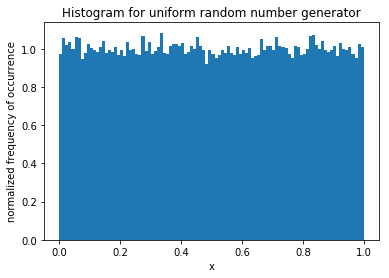

In [14]:
import matplotlib.pyplot as plt

uniSamples = [random.random() for i in range(100000)]
print(uniSamples[0:10])  #Take a look at the first 10
fig, axis = plt.subplots()
axis.hist(uniSamples, bins=100, normed=True)
axis.set_title("Histogram for uniform random number generator")
axis.set_xlabel("x")
axis.set_ylabel("normalized frequency of occurrence")
#fig.savefig("UniformHistogram.png")
plt.show()

[10.511467802559109, 6.909917537794648, 12.43291125214551, 14.1607917633737, 10.890813024128443, 6.273124621973809, 8.413196765556052, 8.174208390916425, 9.155500015611803, 8.086529441435813]


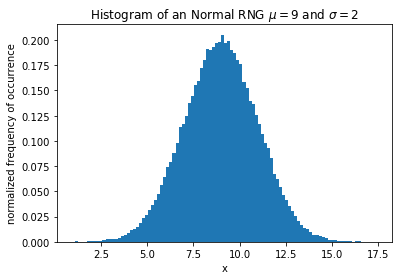

In [13]:
normSamples = [random.normalvariate(9.0, 2.0) for i in range(100000)]
print(normSamples[0:10])  #Take a look at the first 10
fig, axis = plt.subplots()
axis.hist(normSamples, bins=100, normed=True)
axis.set_title(r"Histogram of an Normal RNG $\mu = 9$ and $\sigma = 2$")
axis.set_xlabel("x")
axis.set_ylabel("normalized frequency of occurrence")
plt.show()

Example 1: Two Packet Generators and a Sink

In [17]:
from random import expovariate
from SimComponents import PacketGenerator, PacketSink

def constArrival():  # Constant arrival distribution for generator 1
    return 1.5

def constArrival2():
    return 2.0

def distSize():
    return expovariate(0.01)

env = simpy.Environment()  # Create the SimPy environment
# Create the packet generators and sink
ps = PacketSink(env, debug=True)  # debugging enable for simple output
pg1 = PacketGenerator(env, "EE283", constArrival, distSize)
pg2 = PacketGenerator(env, "SJSU", constArrival2, distSize)
# Wire packet generators and sink together
pg1.out = ps
pg2.out = ps
env.run(until=20)


id: 1, src: EE283, time: 1.5, size: 68.24891559942742
id: 1, src: SJSU, time: 2.0, size: 173.2066445724934
id: 2, src: EE283, time: 3.0, size: 76.60599738870125
id: 2, src: SJSU, time: 4.0, size: 82.47202307578965
id: 3, src: EE283, time: 4.5, size: 169.09063190605312
id: 3, src: SJSU, time: 6.0, size: 5.297181770359698
id: 4, src: EE283, time: 6.0, size: 48.92638367071149
id: 5, src: EE283, time: 7.5, size: 26.953056324602088
id: 4, src: SJSU, time: 8.0, size: 103.49135577378831
id: 6, src: EE283, time: 9.0, size: 43.730997865791544
id: 5, src: SJSU, time: 10.0, size: 83.93338603781352
id: 7, src: EE283, time: 10.5, size: 56.622764489533196
id: 6, src: SJSU, time: 12.0, size: 192.31761872873983
id: 8, src: EE283, time: 12.0, size: 234.15930623519236
id: 9, src: EE283, time: 13.5, size: 19.06897804930875
id: 7, src: SJSU, time: 14.0, size: 318.4943079979064
id: 10, src: EE283, time: 15.0, size: 128.1579968242948
id: 8, src: SJSU, time: 16.0, size: 73.54267376084093
id: 11, src: EE283, 

Example 2: Overloaded Switch Port

In [18]:
from SimComponents import PacketGenerator, PacketSink, SwitchPort

def constArrival():
    return 1.5    # time interval

def constSize():
    return 100.0  # bytes

env = simpy.Environment()  # Create the SimPy environment
ps = PacketSink(env, debug=True) # debug: every packet arrival is printed
pg = PacketGenerator(env, "SJSU", constArrival, constSize)
switch_port = SwitchPort(env, rate=200.0, qlimit=300)
# Wire packet generators and sinks together
pg.out = switch_port
switch_port.out = ps
env.run(until=20)
print("waits: {}".format(ps.waits))
print("received: {}, dropped {}, sent {}".format(ps.packets_rec,
     switch_port.packets_drop, pg.packets_sent))

id: 1, src: SJSU, time: 1.5, size: 100.0
id: 2, src: SJSU, time: 3.0, size: 100.0
id: 3, src: SJSU, time: 4.5, size: 100.0
id: 4, src: SJSU, time: 6.0, size: 100.0
waits: [4.0, 6.5, 9.0, 11.5]
received: 4, dropped 6, sent 13


Example 3: An M/M/1 Queueing System

In [19]:
import random
import functools
import simpy
import matplotlib.pyplot as plt
from SimComponents import PacketGenerator, PacketSink, SwitchPort, PortMonitor

adist = functools.partial(random.expovariate, 0.5)
sdist = functools.partial(random.expovariate, 0.01)  # mean size 100 bytes
samp_dist = functools.partial(random.expovariate, 1.0)
port_rate = 1000.0

env = simpy.Environment()  # Create the SimPy environment
# Create the packet generators and sink
ps = PacketSink(env, debug=False, rec_arrivals=True)
pg = PacketGenerator(env, "Greg", adist, sdist)
switch_port = SwitchPort(env, port_rate, qlimit=10000)
# Using a PortMonitor to track queue sizes over time
pm = PortMonitor(env, switch_port, samp_dist)
# Wire packet generators, switch ports, and sinks together
pg.out = switch_port
switch_port.out = ps
# Run it
env.run(until=8000)
print("Last 10 waits: "  + ", ".join(["{:.3f}".format(x) for x in ps.waits[-10:]]))
print("Last 10 queue sizes: {}".format(pm.sizes[-10:]))
print("Last 10 sink arrival times: " + ", ".join(["{:.3f}".format(x) for x in ps.arrivals[-10:]]))
print("average wait = {:.3f}".format(sum(ps.waits)/len(ps.waits)))
print("received: {}, dropped {}, sent {}".format(switch_port.packets_rec, switch_port.packets_drop, pg.packets_sent))
print("loss rate: {}".format(float(switch_port.packets_drop)/switch_port.packets_rec))
print("average system occupancy: {:.3f}".format(float(sum(pm.sizes))/len(pm.sizes)))


Last 10 waits: 0.310, 0.214, 0.907, 1.426, 0.245, 1.492, 1.543, 1.354, 1.209, 1.131
Last 10 queue sizes: [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Last 10 sink arrival times: 2.299, 0.397, 7.196, 0.888, 1.641, 2.285, 0.264, 0.074, 3.774, 5.148
average wait = 1.310
received: 3926, dropped 0, sent 3926
loss rate: 0.0
average system occupancy: 0.638


In [ ]:
Simulating & Analyzing Networks of Queues

In [20]:
from SimComponents import PacketGenerator, PacketSink, SwitchPort, RandomBrancher


if __name__ == '__main__':
    # Set up arrival and packet size distributions
    # Using Python functools to create callable functions for random variates with fixed parameters.
    # each call to these will produce a new random value.
    mean_pkt_size = 100.0  # in bytes
    adist1 = functools.partial(random.expovariate, 2.0)
    adist2 = functools.partial(random.expovariate, 0.5)
    adist3 = functools.partial(random.expovariate, 0.6)
    sdist = functools.partial(random.expovariate, 1.0/mean_pkt_size)
    samp_dist = functools.partial(random.expovariate, 0.50)
    port_rate = 2.2*8*mean_pkt_size  # want a rate of 2.2 packets per second

    # Create the SimPy environment. This is the thing that runs the simulation.
    env = simpy.Environment()

    # Create the packet generators and sink
    def selector(pkt):
        return pkt.src == "SJSU1"

    def selector2(pkt):
        return pkt.src == "SJSU2"
    ps1 = PacketSink(env, debug=False, rec_arrivals=True, selector=selector)
    ps2 = PacketSink(env, debug=False, rec_waits=True, selector=selector2)
    pg1 = PacketGenerator(env, "SJSU1", adist1, sdist)
    pg2 = PacketGenerator(env, "SJSU2", adist2, sdist)
    pg3 = PacketGenerator(env, "SJSU3", adist3, sdist)
    branch1 = RandomBrancher(env, [0.75, 0.25])
    branch2 = RandomBrancher(env, [0.65, 0.35])
    switch_port1 = SwitchPort(env, port_rate)
    switch_port2 = SwitchPort(env, port_rate)
    switch_port3 = SwitchPort(env, port_rate)
    switch_port4 = SwitchPort(env, port_rate)

    # Wire packet generators, switch ports, and sinks together
    pg1.out = switch_port1
    switch_port1.out = branch1
    branch1.outs[0] = switch_port2
    switch_port2.out = branch2
    branch2.outs[0] = switch_port3
    branch2.outs[1] = switch_port4
    pg3.out = switch_port3
    pg2.out = switch_port4
    switch_port3.out = ps1
    switch_port4.out = ps2
    # Run it
    env.run(until=4000)
    print(ps2.waits[-10:])
    # print pm.sizes[-10:]
    # print ps.arrivals[-10:]
    print("average wait source 1 to output 3 = {}".format(sum(ps1.waits)/len(ps1.waits)))
    print("average wait source 2 to output 4 = {}".format(sum(ps2.waits)/len(ps2.waits)))
    print("packets sent {}".format(pg1.packets_sent + pg2.packets_sent))
    print("packets received: {}".format(len(ps2.waits)))
    # print "average system occupancy: {}".format(float(sum(pm.sizes))/len(pm.sizes))

[2.0144142574276884, 0.7633006927512724, 0.29231080580257185, 1.3776344171437813, 1.9697857578653384, 0.5769779545289566, 0.35530552346654076, 0.4452706364345431, 0.013437754066217167, 0.5117381792679225]
average wait source 1 to output 3 = 6.625285259993739
average wait source 2 to output 4 = 0.7953334275255841
packets sent 9942
packets received: 2018


# Simpy queue simulation
https://stackoverflow.com/questions/49732721/simpy-queue-simulation

In [ ]:
RANDOM_SEED = 42
NEW_CUSTOMERS = 100  # Total number of customers
INTERVAL_CUSTOMERS = 1  # Generate new customers roughly every x seconds
SIZE = 1250

def source(env, number, interval, port):
    """Source generates packet randomly"""
    for i in range(number):
        size =  int(random.expovariate(0.0008))
        packet = Packet(env, '%d' % i, size, port, time_in_port=1)
        env.process(packet)
        t = random.expovariate(1 / interval)
        yield env.timeout(t)

def Packet(env, id, size, port, time_in_port):
    arrive = env.now
    yield Queue.buffer.put(size)
    print('packet%s %s arriving at %lf' % (id, size, arrive))

    with port.request() as req:
        yield req

        tip = random.expovariate(1/time_in_port)
        yield env.timeout(tip)
        amount = size
        yield Queue.buffer.get(amount)
        print('packet%s %s finished processing at %lf' % (id, size, env.now))

class queue:     #THIS PART WON'T WORK
    def __init__(self, env):
        self.port = simpy.Resource(env, capacity=1)
        self.buffer = simpy.Container(env, init = 0, capacity=12500)
        self.mon_proc = env.process(self.monitor_tank(env))

    def monitor_tank(self, env):
        while True:
           if self.buffer.level > 12500:
             print('Full at %d' % env.now)


random.seed(RANDOM_SEED)
env = simpy.Environment()
Queue = queue(env)

port = simpy.Resource(env, capacity=1)
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, port))
env.run()